In [ ]:
import requests
import pandas as pd

# Set the API endpoint URL
url = 'https://earthquake.usgs.gov/fdsnws/event/1/query'

# Define the bounding box for the area of interest
min_latitude = 0
max_latitude = 60
min_longitude = 117 #134 maybe better
max_longitude = 165 #170 maybe better

# Create an empty list to hold the earthquake data
earthquakes = []

for year in range(1973, 2023):
    for month in range(1, 13):
        # Set the parameters for the API request
        starttime = f'{year}-{month:02d}-01'
        endtime = f'{year}-{month+1:02d}-01'
        if month == 12:
            endtime = f'{year+1}-01-01'
        params = {
            'format': 'geojson',
            'starttime': starttime,
            'endtime': endtime,
            'minmagnitude': '0',
            'maxmagnitude': '10',
            'minlatitude': min_latitude,
            'maxlatitude': max_latitude,
            'minlongitude': min_longitude,
            'maxlongitude': max_longitude
        }

        # Send the API request and get the response
        response = requests.get(url, params=params)

        # Parse the JSON response
        data = response.json()

        # Extract the data for each earthquake and append it to the list
        for feature in data['features']:
            longitude = feature['geometry']['coordinates'][0]
            latitude = feature['geometry']['coordinates'][1]
            time = pd.to_datetime(feature['properties']['time'], unit='ms')
            magnitude = feature['properties']['mag']
            earthquake = {'Longitude': longitude, 'Latitude': latitude, 'Time': time, 'Magnitude': magnitude}
            earthquakes.append(earthquake)

# Create a DataFrame from the list of earthquake data
df = pd.DataFrame(earthquakes)

# Print the first few rows of the DataFrame
print(df.head())
print(df.shape, df.Magnitude.min())


In [ ]:
df.to_csv('data/Japan2_1973_2023.csv')

In [ ]:
import pandas as pd
df = pd.read_csv('data/Japan2_1973_2023.csv')

In [ ]:
import cartopy.crs as crs
import cartopy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as mticker

df = df.sort_values('Magnitude')
# Create a map using Cartopy to display earthquake data with magnitudes, longitude, and latitude
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(1, 1, 1, projection=crs.Mercator())
ax.add_feature(cartopy.feature.LAND, facecolor=[.8,.8,.8])
ax.add_feature(cartopy.feature.OCEAN, facecolor=[.95,.95,.95])
ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)

# Add gridlines
lon = np.linspace(-180,180,361)
lat = np.linspace(-90,90,181)

gl = ax.gridlines(draw_labels=True)
gl.xlocator = mticker.FixedLocator(lon)
gl.ylocator = mticker.FixedLocator(lat)
gl.top_labels = gl.right_labels = False
gl.rotate_labels = True
#gl.xlabel_style = {'rotation': 45}

# Add coastlines
ax.coastlines(color='black', linewidth=0.5)

# Plot the earthquake data as scatter points
sc = ax.scatter(df['Longitude'], df['Latitude'], c=df['Magnitude'], cmap="inferno", s=np.exp(df['Magnitude'])/100, transform=crs.PlateCarree())

# Set the colorbar and its label
cbar = fig.colorbar(sc, ax=ax, fraction=0.04, pad=0.02)
cbar.set_label('Magnitude')

# Set the plot title and axis labels
ax.set_title('Earthquakes between 1973 and 2023')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# Set the bounds of the map to the minimum and maximum longitude and latitude values
# Determine the minimum and maximum longitude and latitude values
min_lon, max_lon = df['Longitude'].min(), df['Longitude'].max()
min_lat, max_lat = df['Latitude'].min(), df['Latitude'].max()
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=crs.PlateCarree())


# Show the plot
plt.show()

In [ ]:
from mpl_toolkits.basemap import Basemap
import numpy as np

# Load earthquake data
df = df.sort_values('Magnitude')

# Extract latitude and longitude columns
latitudes = df['Latitude']
longitudes = df['Longitude']
magnitudes = df['Magnitude']

# Set up map projection
fig, ax = plt.subplots(figsize=(16,6))
map = Basemap(projection='merc', lat_0=0, lon_0=0, resolution='l',
              llcrnrlon=min_longitude, llcrnrlat=min_latitude, urcrnrlon=max_longitude, urcrnrlat=max_latitude)

# Draw coastlines, countries, and states
#map.drawcoastlines(color='gray')
map.fillcontinents(color='lightgray', lake_color='white')
map.drawmapboundary(fill_color='white')

# Draw parallels and meridians
map.drawparallels(range(-90, 90, 30), linewidth=0.5, labels=[1, 0, 0, 0])
meridians = map.drawmeridians(range(-180, 180, 30), linewidth=0.5, labels=[0, 0, 0, 1])

for m in meridians:
    try:
        meridians[m][1][0].set_rotation(45)
    except:
        pass

# Convert latitude and longitude to map coordinates
x, y = map(longitudes, latitudes)

# Plot earthquake magnitudes as circles on the map
map.scatter(x, y, s=np.exp(magnitudes)/50, c=magnitudes, cmap='plasma', alpha=1)

# Add a colorbar
plt.colorbar(label='Magnitude')

# Add a title
plt.title('Earthquake Magnitudes')

# Show the plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt

df['Time'] = pd.to_datetime(df.Time)

fig, ax = plt.subplots(figsize=(16,6))
plt.scatter(df.Time, df.Magnitude, s=1)
plt.ylabel('Magnitude')
plt.xlabel('Year')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with a grid of subplots
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(3, 3)

# Define the position of the scatter plot and histograms
ax_scatter = fig.add_subplot(gs[1:, :-1])
ax_hist_x = fig.add_subplot(gs[0, :-1], sharex=ax_scatter)
ax_hist_y = fig.add_subplot(gs[1:, -1], sharey=ax_scatter)

# Plot the scatter plot
ax_scatter.scatter(df.Time, df.Magnitude, s=1)
ax_scatter.set_xlabel('X')
ax_scatter.set_ylabel('Y')

# Plot the histograms
ax_hist_x.hist(df.Time, bins=100)
ax_hist_y.hist(df.Magnitude, bins=90, orientation='horizontal')
ax_hist_x.set_ylabel('Frequency')
ax_hist_y.set_xlabel('Frequency')

# Remove the tick labels on the histograms that overlap with the scatter plot
plt.setp(ax_hist_x.get_xticklabels(), visible=False)
plt.setp(ax_hist_y.get_yticklabels(), visible=False)

# Adjust the spacing of the subplots
fig.tight_layout(h_pad=0, w_pad=0)

# Display the plot
plt.show()



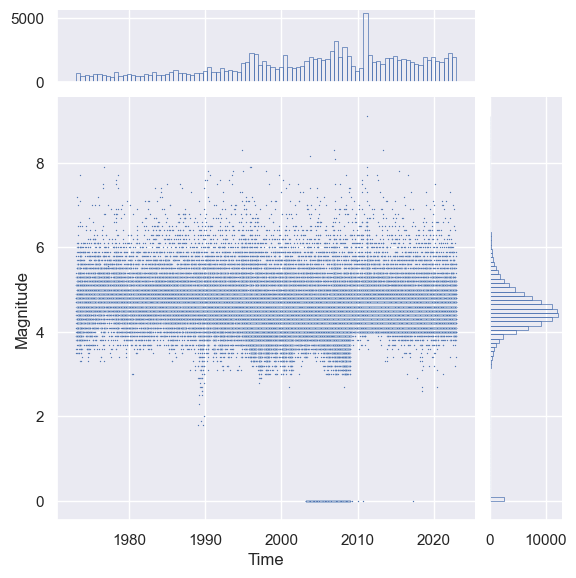

In [25]:
import seaborn as sns
sns.jointplot(
    data=df, x="Time", y="Magnitude", s=1, marginal_ticks=True, marginal_kws=dict(bins=90, fill=False)
)

In [ ]:
emdat = pd.read_excel("/Users/jurrienboogert/Downloads/emdat_public_2023_02_08_query_uid-jHccdA.xlsx", header=6)

In [ ]:
emdat[emdat['Disaster Type'] == 'Earthquake'][['Dis Mag Value']].max()

In [ ]:
tsv_file='/Users/jurrienboogert/Documents/DATA_SCIENCE_AND_SOCIETY/THESIS/datasets/NOAA/earthquakes-2023-02-11_10-24-26_+0100.tsv'
NOAA=pd.read_table(tsv_file,sep='\t')


In [ ]:
NOAA[(NOAA['Total Deaths'] > 0) | (NOAA['Total Damage ($Mil)'] > 0)]['Mag']

plt.hist(NOAA[(NOAA['Total Deaths'] > 0) | (NOAA['Total Damage ($Mil)'] > 0)]['Mag'], bins=80)
plt.show()

NOAA[(NOAA['Total Deaths'] > 0) | (NOAA['Total Damage ($Mil)'] > 0)]['Mag'].quantile(.025)

In [ ]:
NOAA.columns

In [ ]:
pd.to_datetime(NOAA[NOAA['Year'] > 2010][['year', 'month', 'day', 'hour', 'minute']])

In [ ]:
chunk1 = pd.read_csv("/Users/jurrienboogert/Documents/DATA_SCIENCE_AND_SOCIETY/THESIS/datasets/STEAD/chunk1.csv", low_memory=False)
chunk2 = pd.read_csv("/Users/jurrienboogert/Documents/DATA_SCIENCE_AND_SOCIETY/THESIS/datasets/STEAD/chunk2.csv", low_memory=False)
chunk3 = pd.read_csv("/Users/jurrienboogert/Documents/DATA_SCIENCE_AND_SOCIETY/THESIS/datasets/STEAD/chunk3.csv", low_memory=False)
chunk4 = pd.read_csv("/Users/jurrienboogert/Documents/DATA_SCIENCE_AND_SOCIETY/THESIS/datasets/STEAD/chunk4.csv", low_memory=False)
chunk5 = pd.read_csv("/Users/jurrienboogert/Documents/DATA_SCIENCE_AND_SOCIETY/THESIS/datasets/STEAD/chunk5.csv", low_memory=False)
chunk6 = pd.read_csv("/Users/jurrienboogert/Documents/DATA_SCIENCE_AND_SOCIETY/THESIS/datasets/STEAD/chunk6.csv", low_memory=False)

chunks = pd.concat([chunk2,chunk3,chunk4,chunk5,chunk6], ignore_index=True)
chunks['trace_start_time'] = pd.to_datetime(chunks['trace_start_time'])
chunks['source_origin_time'] = pd.to_datetime(chunks['source_origin_time'])
chunks = chunks.sort_values('source_origin_time')

In [ ]:
import matplotlib.pyplot as plt

subset = chunks[(chunks['source_longitude'] >= 19) & (chunks['source_longitude'] <= 30) & (chunks['source_latitude'] >= 34) & (chunks['source_latitude'] <= 44) & (chunks['source_origin_time'] <= '2015-6-25 03:14:47.900')]
fig, ax = plt.subplots(figsize=(16,6))
plt.scatter(subset.source_origin_time, subset.source_magnitude, s=1)
plt.ylabel('Magnitude')
plt.xlabel('Year')

In [ ]:
plt.hist(subset.source_magnitude, bins=48)
plt.xlabel('magnitude')
plt.ylabel('Number of Earthquakes')
plt.title('Histogram of Earthquakes by magnitude')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

# create a histogram of the longitude values
plt.hist(subset.source_latitude, bins=360)
plt.xlabel('Longitude')
plt.ylabel('Number of Earthquakes')
plt.title('Histogram of Earthquakes by Longitude')
plt.show()

# create a histogram of the latitude values
plt.hist(subset.source_longitude, bins=360)
plt.xlabel('Latitude')
plt.ylabel('Number of Earthquakes')
plt.title('Histogram of Earthquakes by Latitude')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

# Load earthquake data
df = subset[chunks['source_magnitude'] >= 0].sort_values('source_magnitude')

# Extract latitude and longitude columns
latitudes = df['source_latitude']
longitudes = df['source_longitude']
magnitudes = df['source_magnitude']

# Set up map projection
fig, ax = plt.subplots(figsize=(16,6))
map = Basemap(projection='merc', lat_0=0, lon_0=0, resolution='l',
              llcrnrlon=19, llcrnrlat=33, urcrnrlon=30, urcrnrlat=43)

# Draw coastlines, countries, and states
#map.drawcoastlines(color='gray')
map.fillcontinents(color='lightgray', lake_color='white')
map.drawmapboundary(fill_color='white')

# Draw parallels and meridians
map.drawparallels(range(-90, 90, 1), linewidth=0.5, labels=[1, 0, 0, 0])
meridians = map.drawmeridians(range(-180, 180, 1), linewidth=0.5, labels=[0, 0, 0, 1])

for m in meridians:
    try:
        meridians[m][1][0].set_rotation(45)
    except:
        pass

# Convert latitude and longitude to map coordinates
x, y = map(longitudes, latitudes)

# Plot earthquake magnitudes as circles on the map
map.scatter(x, y, s=np.exp(magnitudes)/50, c=magnitudes, cmap='plasma', alpha=1)

# Add a colorbar
plt.colorbar(label='Magnitude')

# Add a title
plt.title('Earthquake Magnitudes')

# Show the plot
plt.show()


In [ ]:
from prophet import Prophet

# group the data by date and location to create the input data for Prophet
data = chunks.groupby([pd.Grouper(key='source_origin_time', freq='D'), 'source_latitude', 'source_longitude']).size().reset_index(name='count')

# rename columns for use with Prophet
data = data.rename(columns={'source_origin_time': 'ds', 'count': 'y'})

# create a Prophet model and fit the data
model = Prophet()
model.fit(data)

# create a future dataframe with predictions for the next 365 days
future = model.make_future_dataframe(periods=7)

# predict the number of earthquakes for the future dates
forecast = model.predict(future)

# plot the forecast
fig = model.plot(forecast, xlabel='Date', ylabel='Number of Earthquakes')


In [ ]:
plt.plot(chunks['source_origin_time'], chunks['source_magnitude'], 'ro', alpha=0.01)

In [ ]:
chunks[['source_magnitude', 'trace_start_time', 'source_origin_time', 'receiver_latitude', 'receiver_longitude', 'source_latitude', 'source_longitude']].tail(20)

In [ ]:
chunks[(chunks['source_origin_time'].dt.year == 2007) & (chunks['source_origin_time'].dt.month == 8) & (chunks['source_origin_time'].dt.day == 17) & (chunks['source_origin_time'].dt.hour == 0)]

In [ ]:
chunks[chunks['source_magnitude'] > 6].shape

In [ ]:
NOAA[(NOAA['Year'] > 1983) & (NOAA['Deaths'] > 0)].shape

In [ ]:
temp = pd.read_csv("/Users/jurrienboogert/Downloads/2023.csv", header=None, names=['ID', 'YEAR/MONTH/DAY', 'ELEMENT', 'DATA VALUE', 'M-FLAG', 'Q-FLAG', 'S-FLAG', 'OBS-TIME'])

In [ ]:
dly = pd.read_fwf('/Users/jurrienboogert/Downloads/ghcnd_gsn/ghcnd_gsn/USW00013782.dly')

In [ ]:
source = chunks.sample(1)[['source_latitude', 'source_longitude']]
source.iloc[0,0], source.iloc[0,1]

In [ ]:
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Point, Hourly

# Set time period
start = datetime(1984, 9, 7, 2)
end = datetime(1984, 9, 7, 3)

# Create Point for Vancouver, BC
Point.method = 'nearest'
Point.radius = 200000
Point.max_count = 6
Point.weight_dist = .6
receiver = Point(source.iloc[0,0], source.iloc[0,1])
# Get daily data for 2018
data = Hourly(receiver, start, end)


In [ ]:
chunks['source_origin_time'] = pd.to_datetime(chunks['source_origin_time'])
year = chunks['source_origin_time'].dt.year.fillna(0).astype('int')
month = chunks['source_origin_time'].dt.month.fillna(0).astype('int')
day = chunks['source_origin_time'].dt.day.fillna(0).astype('int')
hour = chunks['source_origin_time'].dt.hour.fillna(0).astype('int')

chunks.source_latitude
chunks.source_longitude

chunks.receiver_latitude
chunks.receiver_longitude
chunks.receiver_elevation_m

In [ ]:
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Point, Hourly

temp_source = []
rhum_source = []
pres_source = []
temp_receiver = []
rhum_receiver = []
pres_receiver = []
counter = 0

Point.method = 'nearest'
Point.radius = 2000000
Point.max_count = 10
Point.weight_dist = .6

for i in range(235426,len(chunks)):
    counter += 1
    start = datetime(year[i], month[i], day[i], hour[i])
    end = start

    source = Point(chunks.source_latitude[i], chunks.source_longitude[i])
    # Get daily data for 2018
    temp_source.append(Hourly(source, start, end).fetch()['temp'][0])
    rhum_source.append(Hourly(source, start, end).fetch()['rhum'][0])
    pres_source.append(Hourly(source, start, end).fetch()['pres'][0])

    if counter % 10 == 0:
        print(counter)


In [ ]:
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Point, Daily

temp_source = []
pres_source = []
temp_receiver = []
pres_receiver = []
counter = 0

Point.method = 'nearest'
Point.radius = 2000000
Point.max_count = 10
Point.weight_dist = .6

for i in range(235426,len(chunks)):
    counter += 1
    start = datetime(year[i], month[i], day[i])
    end = start

    source = Point(chunks.source_latitude[i], chunks.source_longitude[i])
    # Get daily data for 2018
    temp_source.append(Daily(source, start, end).fetch()['tavg'][0])
    pres_source.append(Daily(source, start, end).fetch()['pres'][0])

    Point.alt_range = chunks.receiver_elevation_m[i]
    Point.adapt_temp = True
    receiver = Point(chunks.receiver_latitude[i], chunks.receiver_longitude[i], chunks.receiver_elevation_m[i])
    # Get daily data for 2018
    temp_receiver.append(Daily(receiver, start, end).fetch()['tavg'][0])
    pres_receiver.append(Daily(receiver, start, end).fetch()['pres'][0])
    if counter % 10 == 0:
        print(counter)